In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load pickled dataset into pandas DataFrame
df = pd.read_pickle('preprocess_1.pickle')

display(df.head())

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales_IT,sales_RandD,...,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,0,0,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.80,0.86,0,0,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.11,0.88,1,0,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.72,0.87,0,0,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.37,0.52,0,0,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [3]:
# Split into train, test sets
from sklearn.model_selection import train_test_split

features = df.drop(['left'], axis=1, inplace=False)
target = df['left']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 11999 samples.
Testing set has 3000 samples.


In [4]:
# Search for optimal parameters
from sklearn.model_selection import GridSearchCV

# Parameters to do GridSearch on
cv_params = {
            'max_depth': [6, 10]
            }

# XGBoost parameters
ind_params = {
            'learning_rate': 0.3,
            'objective': 'binary:logistic',
            'seed': 42,
            'subsample': 1
             }

# Initialize GridSearch with its parameters
optimized_GBM = GridSearchCV(estimator=xgb.XGBClassifier(**ind_params), 
                             param_grid=cv_params, 
                             scoring='accuracy',
                             cv=5,
                             n_jobs=-1)

optimized_GBM.fit(X_train, y_train)
#optimized_GBM.cv_results_
optimized_GBM.best_params_

{'max_depth': 10}

In [6]:
# XGBoost library
# Convert pandas DataFrame to DMatrix to make XGBoost more efficient
dmat = xgb.DMatrix(X_train, y_train)

# Initialize parameters
clf_params = {
              'learning_rate': 0.3, 
              'seed': 42, 
              'subsample': 0.8, 
              'colsample_bytree': 0.8, 
              'objective': 'binary:logistic',
              'max_depth': 12, 
              'min_child_weight': 1
             }

# Apply early stopping CV
clf_cv = xgb.cv(params = clf_params, 
                dtrain = dmat, 
                num_boost_round = 3000, 
                nfold = 5,
                metrics = ['error'],
                early_stopping_rounds = 50)

# Check last 5 row results
clf_cv.tail(5)

,test-error-mean,test-error-std,train-error-mean,train-error-std
117,0.056023,0.002578,0.007816,0.000295
118,0.055690,0.002425,0.007503,0.000263
119,0.055690,0.002810,0.007524,0.000339
120,0.055023,0.002570,0.007420,0.000319
121,0.055023,0.002253,0.007336,0.000276


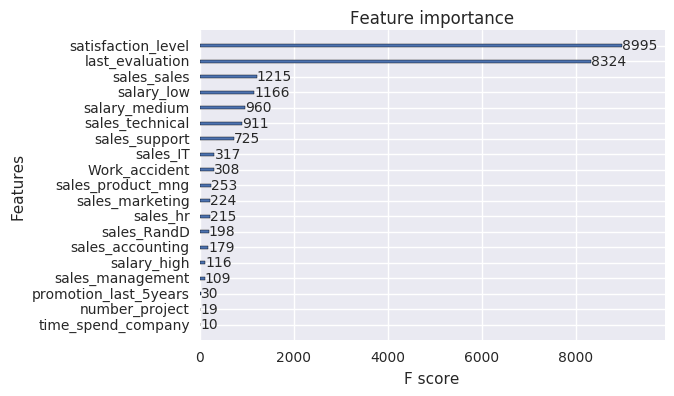

In [7]:
# Train final model
clf_params = {
              'learning_rate': 0.3, 
              'seed':42, 
              'subsample': 0.8, 
              'colsample_bytree': 0.8, 
              'objective': 'binary:logistic', 
              'max_depth':12, 
              'min_child_weight':1
              } 

final_gb = xgb.train(clf_params, dmat, num_boost_round = 235)

# Plot the feature importance
xgb.plot_importance(final_gb)

In [8]:
# Run XGBoost on test data
testdmat = xgb.DMatrix(X_test, y_test)

# Predict
y_pred = final_gb.predict(testdmat)
y_pred

array([  1.32161422e-05,   8.25898023e-05,   5.03364276e-07, ...,
         5.98070001e-05,   1.53357175e-03,   9.79757369e-01], dtype=float32)

In [9]:
# Since XGBoost outputs probability by default and not class labels,
# We need to convert them to classes with thresholds
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([ 0.,  0.,  0., ...,  0.,  0.,  1.], dtype=float32)

In [10]:
# Calculate accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print "Accuracy:", accuracy_score(y_pred, y_test), "Error:", 1 - accuracy_score(y_pred, y_test)
print classification_report(y_test, y_pred)

Accuracy: 0.946333333333 Error: 0.0536666666667
             precision    recall  f1-score   support

          0       0.97      0.96      0.96      2294
          1       0.87      0.91      0.89       706

avg / total       0.95      0.95      0.95      3000

